<a href="https://colab.research.google.com/github/MyNameIsEldar/Movie_Recommender/blob/main/rec_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#🎥Movie Recommender
Recommendation System using deep learning

##✔️Introduction

Required to build embeddings for each user and movie using **neural networks methods**. These embeddings will be used to find more relevant films for user.

I found [this work](https://arxiv.org/abs/1708.05031) implementing Neural Collaborative Filtering (NCF) for solving recommendation task. So I decided to use this method in my work.

For this task I will use the **full MovieLens 27M dataset**.


##📑Imports

In [115]:
import numpy as np
import pandas as pd
import os
from tqdm.notebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import mean_squared_error, roc_auc_score, f1_score

In [116]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [117]:
device

device(type='cuda')

## 💾Read The Data 

In [ ]:
# Download the data from link
!wget https://files.grouplens.org/datasets/movielens/ml-latest.zip
!unzip ml-latest.zip

In [119]:
PATH = '/content/ml-latest/'

In [120]:
ratings = pd.read_csv(PATH+'ratings.csv')
genome_scores = pd.read_csv(PATH+'genome-scores.csv')
genome_tags = pd.read_csv(PATH+'genome-tags.csv')
links = pd.read_csv(PATH+'links.csv')
movies = pd.read_csv(PATH+'movies.csv')
tags = pd.read_csv(PATH+'tags.csv')

In [121]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


In [122]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27753444 entries, 0 to 27753443
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 847.0 MB


27M is too big dataset for working with. So I will use only 10% of them

In [123]:
rand_userIds = np.random.choice(ratings['userId'].unique(), 
                                size=int(len(ratings['userId'].unique())*0.10), 
                                replace=False)

ratings = ratings.loc[ratings['userId'].isin(rand_userIds)]

print('There are {} rows of data from {} users'.format(len(ratings), len(rand_userIds)))

There are 2838699 rows of data from 28322 users


##📊EDA

The dataset has :

* tag.csv : that contains tags applied to movies by users
* rating.csv : that contains ratings of movies by users
* movie.csv : that contains movie information
* link.csv : that contains identifiers that can be used to link to other sources
* genome_scores.csv : that contains movie-tag relevance data
* genome_tags.csv : that contains tag descriptions



Ratings data will be enough for embedding task 

In [124]:
ratings.rating.value_counts()

4.0    749268
3.0    565782
5.0    409849
3.5    351129
4.5    242936
2.0    190148
2.5    145567
1.0     91293
0.5     46410
1.5     46317
Name: rating, dtype: int64

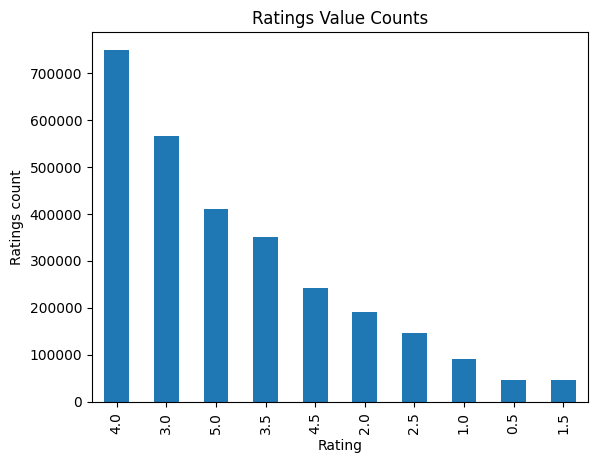

In [125]:
ratings.rating.value_counts().plot(kind='bar')
plt.title('Ratings Value Counts')
plt.ylabel('Ratings count')
plt.xlabel('Rating')
plt.show()

Most frequent rate is 4.0. Rather useres rate movies as 1.0, 0.5 and 1.5

In [126]:
print(f'There are {ratings.movieId.nunique()} unique films in data')

There are 32156 unique films in data


In [127]:
print(f'There are {ratings.userId.nunique()} unique users in data')

There are 28322 unique users in data


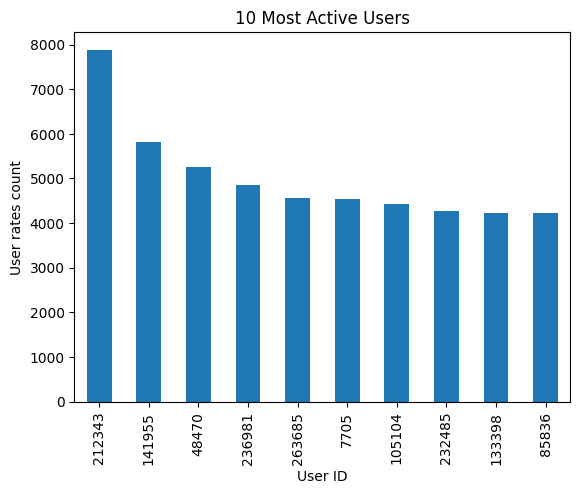

In [128]:
ratings.userId.value_counts()[:10].plot(kind='bar')
plt.title('10 Most Active Users')
plt.ylabel('User rates count')
plt.xlabel('User ID')
plt.show()

One user have more than **20 000** film rates! 

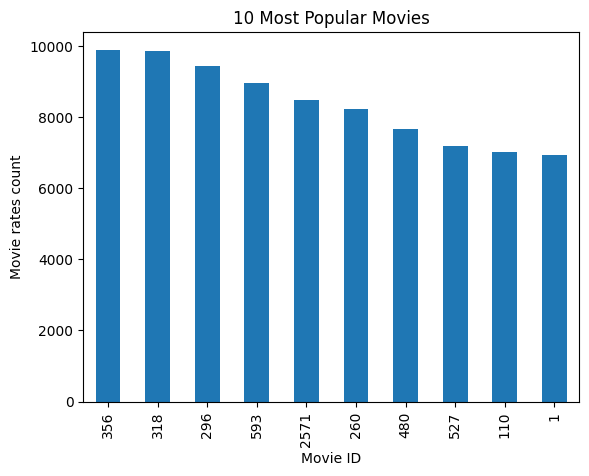

In [129]:
ratings.movieId.value_counts()[:10].plot(kind='bar')
plt.title('10 Most Popular Movies')
plt.ylabel('Movie rates count')
plt.xlabel('Movie ID')
plt.show()

Some of movies has about **100 000 rates**

In [130]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2838699 entries, 42 to 27753330
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 108.3 MB


In [131]:
# change dtype for timestamp
# ratings.timestamp = pd.to_datetime(ratings.timestamp, unit='s', origin='unix')
# ratings.head()

In [132]:
# ratings.info()

Is NA values in data?

In [133]:
ratings.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Is there any duplicates in data?

In [134]:
ratings.duplicated().sum()

0

## ⚙️Data Preproccesing

### Data Split

Along with the rating, there is also a timestamp column that shows the date and time the review was submitted. Using the timestamp column, we will implement our train-test split strategy. For each user, the most recent review is used as the test set, while the rest will be used as training data.

This train-test split strategy is often used when training and evaluating recommender systems. Doing a random split would not be fair, as we could potentially be using a user's recent reviews for training and earlier reviews for testing. This introduces data leakage with a look-ahead bias, and the performance of the trained model would not be generalizable to real-world performance.

The code below will split our ratings dataset into a train and test set.

In [135]:
ratings['rank_latest'] = ratings.groupby(['userId'])['timestamp'] \
                                .rank(method='first', ascending=False)

train_ratings = ratings[ratings['rank_latest'] != 1]
test_ratings = ratings[ratings['rank_latest'] == 1]

ratings.head(10)

,userId,movieId,rating,timestamp,rank_latest
42,4,1,4.0,1113765937,695.0
43,4,2,4.0,1113767306,541.0
44,4,5,2.0,1123990453,133.0
45,4,6,4.5,1113767242,554.0
46,4,10,4.0,1113765995,684.0
47,4,11,3.5,1113767280,546.0
48,4,16,4.0,1113765691,721.0
49,4,19,2.0,1113767324,538.0
50,4,20,2.5,1145937918,37.0
51,4,23,3.0,1115782385,248.0


In [136]:
train_ratings.head()

,userId,movieId,rating,timestamp,rank_latest
42,4,1,4.0,1113765937,695.0
43,4,2,4.0,1113767306,541.0
44,4,5,2.0,1123990453,133.0
45,4,6,4.5,1113767242,554.0
46,4,10,4.0,1113765995,684.0


In [137]:
test_ratings.head()

,userId,movieId,rating,timestamp,rank_latest
771,4,52950,4.5,1204592934,1.0
1063,11,1193,4.5,1112135548,1.0
1782,19,798,3.0,850304644,1.0
2765,41,441,4.0,1173668740,1.0
2837,42,1220,3.5,1310462993,1.0


In [138]:
# drop columns that we no longer need
train_ratings = train_ratings[['userId', 'movieId', 'rating']]
test_ratings = test_ratings[['userId', 'movieId', 'rating']]

Now we have splitted datasets and we will be able to evaluate model correctly

### Converting the dataset into an implicit feedback dataset

Our task - predict if user will watch that film or not. So we need to change target values. Now we have only ratings (numbers between 1 and 5) but we need class implict did user watch the film or not. Let's change ratings to 1.

In [139]:
train_ratings['target'] = 1
train_ratings.head()

,userId,movieId,rating,target
42,4,1,4.0,1
43,4,2,4.0,1
44,4,5,2.0,1
45,4,6,4.5,1
46,4,10,4.0,1


Now we have problem - only positive (1) class. I will solve this problem just addtitng films that user didn't has watch

In [140]:
# Get a list of all movie IDs
all_movieIds = ratings['movieId'].unique()

# Placeholders that will hold the training data
users, items, labels = [], [], []

# This is the set of items that each user has interaction with
user_item_set = set(zip(train_ratings['userId'], train_ratings['movieId']))

In [141]:
# 4:1 ratio of negative to positive samples
num_negatives = 4

for (u, i) in tqdm(user_item_set):
    users.append(u)
    items.append(i)
    labels.append(1) # items that the user has interacted with are positive
    for _ in range(num_negatives):
        # randomly select an item
        negative_item = np.random.choice(all_movieIds) 
        # check that the user has not interacted with this item
        while (u, negative_item) in user_item_set:
            negative_item = np.random.choice(all_movieIds)
        users.append(u)
        items.append(negative_item)
        labels.append(0) # items not interacted with are negative

  0%|          | 0/2810377 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [142]:
class MovieLensDataset(Dataset):
    """MovieLens PyTorch Dataset for Training
    
    Args:
        ratings (pd.DataFrame): Dataframe containing the movie ratings
        all_movieIds (list): List containing all movieIds
    
    """

    def __init__(self, ratings, all_movieIds, train=True):
        self.users, self.items, self.labels = self.get_dataset(ratings, all_movieIds, train)

    def __len__(self):
        return len(self.users)
  
    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.labels[idx]

    def get_dataset(self, ratings, all_movieIds, train):
        users, items, labels = [], [], []
        user_item_set = set(zip(ratings['userId'], ratings['movieId']))

        num_negatives = 2
        for u, i in tqdm(user_item_set):
            users.append(u)
            items.append(i)
            labels.append(1)
            if train:
              for _ in range(num_negatives):
                  negative_item = np.random.choice(all_movieIds)
                  while (u, negative_item) in user_item_set:
                      negative_item = np.random.choice(all_movieIds)
                  users.append(u)
                  items.append(negative_item)
                  labels.append(0)

        return torch.tensor(users), torch.tensor(items), torch.tensor(labels)

In [143]:
train_dataset = MovieLensDataset(train_ratings, all_movieIds)
train_dataset

  0%|          | 0/2810377 [00:00<?, ?it/s]

In [144]:
test_dataset = MovieLensDataset(test_ratings, all_movieIds, train=False)
test_dataset

  0%|          | 0/28322 [00:00<?, ?it/s]

In [145]:
train_dataloader = DataLoader(train_dataset, batch_size=2048, shuffle=False,
                                  num_workers=1)
test_dataloader = DataLoader(test_dataset, batch_size=2048, shuffle=False,
                                  num_workers=1)

## 🤖Model

### User Embeddings

Before we dive into the architecture of the model, let's familiarize ourselves with the concept of embeddings. An embedding is a low-dimensional space that captures the relationship of vectors from a higher dimensional space. To better understand this concept, let's take a closer look at user embeddings. 

Imagine that we want to represent our users according to their preference for two genres of movies - action and romance movies. Let the first dimension be how much the user likes action movies, and the second dimension be how much the user likes romance movies.

![](https://i.imgur.com/XENzqXq.png)

Now, assume that Bob is our first user. Bob likes action movies but isn't a fan of romance movies. To represent Bob as a two dimensional vector, we place him in the graph according to his preference.

![](https://i.imgur.com/rSStTCj.png)

Our next user is Joe. Joe is a huge fan of both action and romance movies. We represent Joe using a two dimensional vector just like Bob.

![](https://i.imgur.com/gmmkrEU.png)

This two dimensional space is known as an embedding. Essentially, the embedding reduces our users such that they can be represented in a meaningful manner in a lower dimensional space. In this embedding, users with similar movie preferences are placed near to each other, and vice versa. 

![](https://i.imgur.com/9s9Z7JT.png)

Of course, we are not restricted to using just 2 dimensions to represent our users. We can use an arbitrary number of dimensions to represent our users. A larger number of dimensions would allow us to capture the traits of each user more accurately, at the cost of model complexity. In our code, we'll use 8 dimensions (which we will see later).

### Learned Embeddings

Similarly, we will use a separate item embedding layer to represent the traits of the items (i.e. movies) in a lower dimensional space. 

You might be wondering, how can we learn the weights of the embedding layer, such that it provides an accurate representation of users and items? In our previous example, we used Bob and Joe's preference for action and romance movies to manually create our embedding. Is there a way to learn such preferences automatically? 

The answer is **Collaborative Filtering** - by using the ratings dataset, we can identify similar users and movies, creating user and item embeddings learned from existing ratings.

### Model Architecture

Now that we have a better understanding of embeddings, we are ready to define the model architecture. As you'll see, the user and item embeddings are key to the model.

<!-- ![NCF](https://i.imgur.com/EZh1HHf.png)
 -->
 
Let's walk through the model architecture using the following training sample:

| userId | movieID | interacted |
|-|-|-|
| 3 | 1 | 1 |

 
![](https://i.imgur.com/cNWbIce.png)


The inputs to the model are the one-hot encoded user and item vector for `userId = 3` and `movieId = 1`. Because this is a positive sample (movie actually rated by the user), the true label (`interacted`) is 1.

The user input vector and item input vector are fed to the user embedding and item embedding respectively, which results in a smaller, denser user and item vectors. 

The embedded user and item vectors are concatenated before passing through a series of fully connected layers, which maps the concatenated embeddings into a prediction vector as output. Finally, we apply a `Sigmoid` function to obtain the most probable class. In the example above, the most probable class is 1 (positive class), since 0.8 > 0.2.

In [146]:
class NCF(nn.Module):
    """ Neural Collaborative Filtering (NCF)
    
        Args:
            num_users (int): Number of unique users
            num_items (int): Number of unique items
            ratings (pd.DataFrame): Dataframe containing the movie ratings for training
            all_movieIds (list): List containing all movieIds (train + test)
    """
    
    def __init__(self, num_users, num_items, ratings, all_movieIds):
        super().__init__()
        self.user_embedding = nn.Embedding(num_embeddings=num_users, embedding_dim=8)
        self.item_embedding = nn.Embedding(num_embeddings=num_items, embedding_dim=8)
        self.fc1 = nn.Linear(in_features=16, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=32)
        self.output = nn.Linear(in_features=32, out_features=1)
        self.ratings = ratings
        self.all_movieIds = all_movieIds
        
    def forward(self, user_input, item_input):
        
        # Pass through embedding layers
        user_embedded = self.user_embedding(user_input)
        item_embedded = self.item_embedding(item_input)

        # Concat the two embedding layers
        vector = torch.cat([user_embedded, item_embedded], dim=-1)

        # Pass through dense layer
        vector = nn.ReLU()(self.fc1(vector))
        vector = nn.ReLU()(self.fc2(vector))

        # Output layer
        pred = nn.Sigmoid()(self.output(vector))

        return pred
    
    def training_step(self, predicted_labels, labels):
        predicted_labels = predicted_labels
        loss = nn.BCELoss()(predicted_labels, labels.view(-1, 1).float())
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

In [147]:
# Train function
def train_nn(net, num_epochs, train, test, metric=f1_score):
  f1_vals = []
  epochs = []
  optimizer = net.configure_optimizers()

  for epoch in tqdm(range(num_epochs)):

    for batch in tqdm(train):
        users_train, movies_train, labels_train = batch
        optimizer.zero_grad()

        preds = net.forward(users_train, movies_train)

        loss_value = net.training_step(preds, labels_train)
        loss_value.backward()
        optimizer.step()

    if epoch % 1 == 0:
        predicted_films = []
        all_test_labels = [] 
        with torch.no_grad():
            net.eval()
            for batch in test:
                users_test, movies_test, labels_test = batch

                test_preds = net.forward(users_test, movies_test)
                
                predicted_films.append(test_preds)
                all_test_labels.append(labels_test)

        all_test_labels = torch.cat(all_test_labels).detach().numpy()
        predicted_films = torch.cat(predicted_films).round().detach().numpy()
        F1 = metric(all_test_labels, predicted_films)
        # early_stopping(F1)
        print(f"epoch:{epoch}, F1 test: {F1}")

        # if early_stopping.early_stop:
        #     print('Early Stoppning!!!')
        #     break

In [156]:
num_users = ratings['userId'].max()+1
num_items = ratings['movieId'].max()+1

all_movieIds = ratings['movieId'].unique()

model = NCF(num_users, num_items, train_ratings, all_movieIds)

How embeddings looks like

In [149]:
emb = nn.Embedding(num_embeddings=num_users, embedding_dim=4)
emb_t = emb(torch.tensor(users))
emb_t

tensor([[-0.2154, -0.2721, -0.3059, -1.2591],
        [-0.2154, -0.2721, -0.3059, -1.2591],
        [-0.2154, -0.2721, -0.3059, -1.2591],
        ...,
        [-0.2821,  0.8225,  0.3283,  0.5934],
        [ 0.0620,  0.7419,  0.9667,  0.9454],
        [ 0.0620,  0.7419,  0.9667,  0.9454]], grad_fn=<EmbeddingBackward0>)

In [150]:
emb_t.shape

torch.Size([2189537, 4])

In [151]:
# %%time
# trainer = pl.Trainer(max_epochs=3, reload_dataloaders_every_n_epochs=1,
#                      accelerator="gpu", enable_progress_bar=True, logger=False, 
#                      enable_checkpointing=False)

# trainer.fit(model)

In [157]:
train_nn(model, 1, train_dataloader, test_dataloader)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4117 [00:00<?, ?it/s]

epoch:0, F1 test: 0.9101054413915186


### Evaluating our Recommender System

Now that our model is trained, we are ready to evaluate it using the test data. In traditional Machine Learning projects, we evaluate our models using metrics such as Accuracy (for classification problems) and RMSE (for regression problems). However, such metrics are too simplistic for evaluating recommender systems.

To design a good metric for evaluating recommender systems, we need to first understand how modern recommender systems are used.

The key here is that we don't need the user to interact on every single item in the list of recommendations. Instead, we just need the user to interact with at least one item on the list - as long as the user does that, the recommendations have worked.

To simulate this, let's run the following evaluation protocol to generate a list of 10 recommended items for each user.

* For each user, randomly select 99 items that the user has not interacted with
* Combine these 99 items with the test item (the actual item that the user interacted with). We now have 100 items.
* Run the model on these 100 items, and rank them according to their predicted probabilities
* Select the top 10 items from the list of 100 items. If the test item is present within the top 10 items, then we say that this is a hit.
* Repeat the process for all users. The Hit Ratio is then the average hits.

This evaluation protocol is known as Hit Ratio @ 10, and it is commonly used to evaluate recommender systems.

Hit Ratio @ 10
Now, let's evaluate our model using the described protocol.

In [153]:
# User-item pairs for testing
test_user_item_set = set(zip(test_ratings['userId'], test_ratings['movieId']))

# Dict of all items that are interacted with by each user
user_interacted_items = ratings.groupby('userId')['movieId'].apply(list).to_dict()

hits = []
for (u,i) in tqdm(test_user_item_set):
    interacted_items = user_interacted_items[u]
    not_interacted_items = set(all_movieIds) - set(interacted_items)
    selected_not_interacted = list(np.random.choice(list(not_interacted_items), 99))
    test_items = selected_not_interacted + [i]
    
    predicted_labels = np.squeeze(model(torch.tensor([u]*100), 
                                        torch.tensor(test_items)).detach().numpy())
    
    top10_items = [test_items[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    
    if i in top10_items:
        hits.append(1)
    else:
        hits.append(0)
        
print("The Hit Ratio @ 10 is {:.2f}".format(np.average(hits)))

  0%|          | 0/28322 [00:00<?, ?it/s]

The Hit Ratio @ 10 is 0.87


We got a pretty good Hit Ratio @ 10 score! To put this into context, what this means is that 87% of the users were recommended the actual item (among a list of 10 items) that they eventually interacted with. Not bad!